In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline
#A100 80GB

In [2]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [3]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

In [4]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility,ACANet_GAT, ACANet_GCN, ACANet_GIN
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [5]:
ACANET_MODEL = ACANet_GAT

In [6]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets

@torch.no_grad()
def test(test_loader, model, aca_loss):
    model.eval()
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    for i, data in enumerate(test_loader):
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse



def Test_performance(alpha=1.0):
    
    model = ACANET_MODEL(**pub_args, heads = 4, concat = False).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, squared=True, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)

        _, _, _, _, train_n_pos_triplets, train_rmse = test(train_loader, model, aca_loss)
        _, _, _, _, val_n_pos_triplets, val_rmse = test(val_loader, model, aca_loss)
        _, _, _, _, test_n_pos_triplets, test_rmse = test(test_loader, model, aca_loss)

        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'train_rmse':train_rmse,'n_triplets': n_triplets, 
                        'n_pos_triplets':n_pos_triplets, 
                        'train_n_pos_triplets':train_n_pos_triplets,
                        'val_n_pos_triplets':val_n_pos_triplets,
                        'test_n_pos_triplets':test_n_pos_triplets,
                       
                       })
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

In [7]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            # 'aggregators': ['mean', 'min', 'max', 'sum','std'],
            # 'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

In [8]:
len(Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42))

1125

In [9]:
# train, valid, test splitting
res1 = []
res2 = []
for seed in [8, 16, 24, 42, 64, 128, 256, 512, 1024, 2048]:
    dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42)
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    deg = get_deg(train_dataset)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # With AC-Awareness ($\alpha = 1$)
    df1 = Test_performance(alpha=1.0)
    df1['seed'] = seed
    # Without AC-Awareness ($\alpha = 0$)
    df2 = Test_performance(alpha=0.0)
    df2['seed'] = seed
    res1.append(df1)
    res2.append(df2)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 353.0876 tsm_loss: 308.8028 reg_loss: 44.2849 n_pos_triplets: 193667;  Val: 6.7673 Test: 6.7879
Epoch: 002, Loss: 173.1448 tsm_loss: 133.8764 reg_loss: 39.2684 n_pos_triplets: 184859;  Val: 6.7671 Test: 6.7876
Epoch: 003, Loss: 122.7127 tsm_loss: 89.0563 reg_loss: 33.6564 n_pos_triplets: 175410;  Val: 6.7677 Test: 6.7882
Epoch: 004, Loss: 94.5468 tsm_loss: 67.8139 reg_loss: 26.7329 n_pos_triplets: 168755;  Val: 6.7667 Test: 6.7872
Epoch: 005, Loss: 74.6543 tsm_loss: 55.5506 reg_loss: 19.1037 n_pos_triplets: 165602;  Val: 6.7611 Test: 6.7816
Epoch: 006, Loss: 57.7493 tsm_loss: 46.3141 reg_loss: 11.4352 n_pos_triplets: 158785;  Val: 6.7268 Test: 6.7473
Epoch: 007, Loss: 45.8294 tsm_loss: 40.6945 reg_loss: 5.1349 n_pos_triplets: 154888;  Val: 6.3991 Test: 6.4190
Epoch: 008, Loss: 37.5101 tsm_loss: 35.9254 reg_loss: 1.5847 n_pos_triplets: 151890;  Val: 5.4670 Test: 5.4851
Epoch: 009, Loss: 33.0965 tsm_loss: 31.9334 reg_loss: 1.1631 n_pos_triplets: 150146;  Val: 4.1730 Tes

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 39.4132 tsm_loss: 437.1019 reg_loss: 39.4132 n_pos_triplets: 197067;  Val: 6.6217 Test: 6.6423
Epoch: 002, Loss: 30.0251 tsm_loss: 434.3243 reg_loss: 30.0251 n_pos_triplets: 193983;  Val: 6.6220 Test: 6.6426
Epoch: 003, Loss: 18.7222 tsm_loss: 478.7718 reg_loss: 18.7222 n_pos_triplets: 193454;  Val: 6.6238 Test: 6.6444
Epoch: 004, Loss: 7.4229 tsm_loss: 472.2377 reg_loss: 7.4229 n_pos_triplets: 189663;  Val: 6.6247 Test: 6.6453
Epoch: 005, Loss: 1.5696 tsm_loss: 378.1141 reg_loss: 1.5696 n_pos_triplets: 185412;  Val: 6.6230 Test: 6.6435
Epoch: 006, Loss: 2.0397 tsm_loss: 294.4957 reg_loss: 2.0397 n_pos_triplets: 172014;  Val: 6.6152 Test: 6.6358
Epoch: 007, Loss: 1.0542 tsm_loss: 284.4827 reg_loss: 1.0542 n_pos_triplets: 165588;  Val: 6.5037 Test: 6.5248
Epoch: 008, Loss: 0.8508 tsm_loss: 278.4429 reg_loss: 0.8508 n_pos_triplets: 165526;  Val: 6.1070 Test: 6.1281
Epoch: 009, Loss: 0.8111 tsm_loss: 272.1330 reg_loss: 0.8111 n_pos_triplets: 165785;  Val: 5.3888 Test: 5.

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 282.6995 tsm_loss: 240.8515 reg_loss: 41.8481 n_pos_triplets: 188420;  Val: 6.6651 Test: 6.6449
Epoch: 002, Loss: 146.4880 tsm_loss: 110.3082 reg_loss: 36.1798 n_pos_triplets: 181766;  Val: 6.6662 Test: 6.6460
Epoch: 003, Loss: 107.9195 tsm_loss: 78.6637 reg_loss: 29.2559 n_pos_triplets: 180977;  Val: 6.6683 Test: 6.6481
Epoch: 004, Loss: 81.5461 tsm_loss: 60.1051 reg_loss: 21.4410 n_pos_triplets: 170874;  Val: 6.6686 Test: 6.6484
Epoch: 005, Loss: 61.8394 tsm_loss: 48.2846 reg_loss: 13.5548 n_pos_triplets: 162074;  Val: 6.6685 Test: 6.6482
Epoch: 006, Loss: 46.2104 tsm_loss: 39.7173 reg_loss: 6.4931 n_pos_triplets: 151746;  Val: 6.6698 Test: 6.6496
Epoch: 007, Loss: 37.7197 tsm_loss: 35.6467 reg_loss: 2.0729 n_pos_triplets: 151713;  Val: 6.5953 Test: 6.5722
Epoch: 008, Loss: 32.3407 tsm_loss: 31.3223 reg_loss: 1.0185 n_pos_triplets: 151464;  Val: 5.9820 Test: 5.9457
Epoch: 009, Loss: 29.5765 tsm_loss: 28.1825 reg_loss: 1.3940 n_pos_triplets: 152576;  Val: 4.9353 Test

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 40.5153 tsm_loss: 470.0257 reg_loss: 40.5153 n_pos_triplets: 196354;  Val: 6.7678 Test: 6.7476
Epoch: 002, Loss: 33.2542 tsm_loss: 460.0832 reg_loss: 33.2542 n_pos_triplets: 191432;  Val: 6.7656 Test: 6.7453
Epoch: 003, Loss: 24.5501 tsm_loss: 508.7535 reg_loss: 24.5501 n_pos_triplets: 193821;  Val: 6.7646 Test: 6.7444
Epoch: 004, Loss: 14.3961 tsm_loss: 556.0699 reg_loss: 14.3961 n_pos_triplets: 192606;  Val: 6.7632 Test: 6.7429
Epoch: 005, Loss: 5.3592 tsm_loss: 542.0894 reg_loss: 5.3592 n_pos_triplets: 191707;  Val: 6.7617 Test: 6.7414
Epoch: 006, Loss: 1.4266 tsm_loss: 399.1190 reg_loss: 1.4266 n_pos_triplets: 180144;  Val: 6.7587 Test: 6.7383
Epoch: 007, Loss: 1.6695 tsm_loss: 321.8330 reg_loss: 1.6695 n_pos_triplets: 175353;  Val: 6.7230 Test: 6.6997
Epoch: 008, Loss: 1.0370 tsm_loss: 293.2982 reg_loss: 1.0370 n_pos_triplets: 177915;  Val: 6.3615 Test: 6.3275
Epoch: 009, Loss: 0.8719 tsm_loss: 290.4903 reg_loss: 0.8719 n_pos_triplets: 174723;  Val: 5.7049 Test: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 320.5880 tsm_loss: 274.8665 reg_loss: 45.7215 n_pos_triplets: 190173;  Val: 6.7915 Test: 6.7715
Epoch: 002, Loss: 174.9177 tsm_loss: 132.3350 reg_loss: 42.5826 n_pos_triplets: 179900;  Val: 6.7880 Test: 6.7681
Epoch: 003, Loss: 126.3347 tsm_loss: 87.1219 reg_loss: 39.2127 n_pos_triplets: 171800;  Val: 6.7829 Test: 6.7629
Epoch: 004, Loss: 103.7080 tsm_loss: 68.5357 reg_loss: 35.1722 n_pos_triplets: 164493;  Val: 6.7781 Test: 6.7582
Epoch: 005, Loss: 85.6079 tsm_loss: 55.3381 reg_loss: 30.2698 n_pos_triplets: 156852;  Val: 6.7743 Test: 6.7544
Epoch: 006, Loss: 70.8592 tsm_loss: 46.5946 reg_loss: 24.2646 n_pos_triplets: 152526;  Val: 6.7656 Test: 6.7456
Epoch: 007, Loss: 58.3722 tsm_loss: 40.9481 reg_loss: 17.4240 n_pos_triplets: 151413;  Val: 6.5908 Test: 6.5717
Epoch: 008, Loss: 46.4874 tsm_loss: 35.8703 reg_loss: 10.6170 n_pos_triplets: 147060;  Val: 5.9618 Test: 5.9449
Epoch: 009, Loss: 36.8168 tsm_loss: 31.7961 reg_loss: 5.0208 n_pos_triplets: 143056;  Val: 4.8497 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 406, Loss: 0.7975 tsm_loss: 0.6892 reg_loss: 0.1083 n_pos_triplets: 49456;  Val: 0.7024 Test: 0.6191
Epoch: 407, Loss: 0.8151 tsm_loss: 0.7046 reg_loss: 0.1105 n_pos_triplets: 53453;  Val: 0.6924 Test: 0.6250
Epoch: 408, Loss: 0.7844 tsm_loss: 0.6773 reg_loss: 0.1072 n_pos_triplets: 50061;  Val: 0.7070 Test: 0.6395
Epoch: 409, Loss: 0.8129 tsm_loss: 0.7059 reg_loss: 0.1070 n_pos_triplets: 51916;  Val: 0.6926 Test: 0.6203
Epoch: 410, Loss: 0.8834 tsm_loss: 0.7667 reg_loss: 0.1168 n_pos_triplets: 55234;  Val: 0.6966 Test: 0.6198
Epoch: 411, Loss: 0.7871 tsm_loss: 0.6715 reg_loss: 0.1156 n_pos_triplets: 50389;  Val: 0.7164 Test: 0.6374
Epoch: 412, Loss: 0.8108 tsm_loss: 0.7057 reg_loss: 0.1050 n_pos_triplets: 50990;  Val: 0.7083 Test: 0.6211
Epoch: 413, Loss: 0.7965 tsm_loss: 0.7015 reg_loss: 0.0950 n_pos_triplets: 52918;  Val: 0.7020 Test: 0.6234
Epoch: 414, Loss: 0.7627 tsm_loss: 0.6615 reg_loss: 0.1012 n_pos_triplets: 49144;  Val: 0.6971 Test: 0.6250
Epoch: 415, Loss: 0.7408 tsm

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 46.1615 tsm_loss: 463.4071 reg_loss: 46.1615 n_pos_triplets: 195143;  Val: 6.8957 Test: 6.8759
Epoch: 002, Loss: 39.9072 tsm_loss: 444.2863 reg_loss: 39.9072 n_pos_triplets: 189608;  Val: 6.8981 Test: 6.8783
Epoch: 003, Loss: 31.9712 tsm_loss: 472.6044 reg_loss: 31.9712 n_pos_triplets: 189882;  Val: 6.8975 Test: 6.8777
Epoch: 004, Loss: 22.1239 tsm_loss: 508.7910 reg_loss: 22.1239 n_pos_triplets: 188204;  Val: 6.8954 Test: 6.8755
Epoch: 005, Loss: 11.5294 tsm_loss: 506.4493 reg_loss: 11.5294 n_pos_triplets: 187910;  Val: 6.8907 Test: 6.8708
Epoch: 006, Loss: 3.2362 tsm_loss: 493.2770 reg_loss: 3.2362 n_pos_triplets: 184554;  Val: 6.8853 Test: 6.8655
Epoch: 007, Loss: 1.6392 tsm_loss: 406.5608 reg_loss: 1.6392 n_pos_triplets: 178441;  Val: 6.8424 Test: 6.8239
Epoch: 008, Loss: 1.6778 tsm_loss: 353.2674 reg_loss: 1.6778 n_pos_triplets: 173267;  Val: 6.4345 Test: 6.4158
Epoch: 009, Loss: 0.8911 tsm_loss: 309.3430 reg_loss: 0.8911 n_pos_triplets: 167805;  Val: 5.7475 Test

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 249.7930 tsm_loss: 203.5936 reg_loss: 46.1993 n_pos_triplets: 194901;  Val: 6.7463 Test: 6.5285
Epoch: 002, Loss: 145.7029 tsm_loss: 104.5786 reg_loss: 41.1243 n_pos_triplets: 184757;  Val: 6.7472 Test: 6.5294
Epoch: 003, Loss: 107.7141 tsm_loss: 71.5014 reg_loss: 36.2127 n_pos_triplets: 176212;  Val: 6.7506 Test: 6.5327
Epoch: 004, Loss: 86.1749 tsm_loss: 56.1370 reg_loss: 30.0379 n_pos_triplets: 171181;  Val: 6.7516 Test: 6.5338
Epoch: 005, Loss: 68.2888 tsm_loss: 45.3172 reg_loss: 22.9716 n_pos_triplets: 165753;  Val: 6.7463 Test: 6.5285
Epoch: 006, Loss: 53.6598 tsm_loss: 37.9832 reg_loss: 15.6766 n_pos_triplets: 161459;  Val: 6.7338 Test: 6.5158
Epoch: 007, Loss: 40.9021 tsm_loss: 32.0006 reg_loss: 8.9015 n_pos_triplets: 155646;  Val: 6.4795 Test: 6.2598
Epoch: 008, Loss: 32.3690 tsm_loss: 28.4938 reg_loss: 3.8752 n_pos_triplets: 153488;  Val: 5.6475 Test: 5.4278
Epoch: 009, Loss: 26.1397 tsm_loss: 24.7145 reg_loss: 1.4253 n_pos_triplets: 148547;  Val: 4.3186 Tes

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 43.2749 tsm_loss: 365.8210 reg_loss: 43.2749 n_pos_triplets: 195082;  Val: 6.6970 Test: 6.4792
Epoch: 002, Loss: 36.2082 tsm_loss: 403.1921 reg_loss: 36.2082 n_pos_triplets: 194112;  Val: 6.6954 Test: 6.4776
Epoch: 003, Loss: 27.2729 tsm_loss: 382.6952 reg_loss: 27.2729 n_pos_triplets: 191286;  Val: 6.6936 Test: 6.4758
Epoch: 004, Loss: 16.0090 tsm_loss: 370.8022 reg_loss: 16.0090 n_pos_triplets: 190587;  Val: 6.6915 Test: 6.4737
Epoch: 005, Loss: 5.7451 tsm_loss: 371.0021 reg_loss: 5.7451 n_pos_triplets: 184460;  Val: 6.6869 Test: 6.4691
Epoch: 006, Loss: 1.2896 tsm_loss: 350.2724 reg_loss: 1.2896 n_pos_triplets: 178159;  Val: 6.6709 Test: 6.4528
Epoch: 007, Loss: 2.0005 tsm_loss: 319.7853 reg_loss: 2.0005 n_pos_triplets: 175844;  Val: 6.5643 Test: 6.3457
Epoch: 008, Loss: 0.9624 tsm_loss: 278.8721 reg_loss: 0.9624 n_pos_triplets: 176411;  Val: 6.1176 Test: 5.9037
Epoch: 009, Loss: 0.8889 tsm_loss: 243.8590 reg_loss: 0.8889 n_pos_triplets: 172109;  Val: 5.2716 Test: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 322.9868 tsm_loss: 276.4998 reg_loss: 46.4870 n_pos_triplets: 192085;  Val: 6.8074 Test: 6.7558
Epoch: 002, Loss: 171.0463 tsm_loss: 129.7419 reg_loss: 41.3044 n_pos_triplets: 182412;  Val: 6.8124 Test: 6.7608
Epoch: 003, Loss: 121.1740 tsm_loss: 86.0036 reg_loss: 35.1703 n_pos_triplets: 175521;  Val: 6.8155 Test: 6.7638
Epoch: 004, Loss: 93.4946 tsm_loss: 65.9305 reg_loss: 27.5642 n_pos_triplets: 169559;  Val: 6.8130 Test: 6.7614
Epoch: 005, Loss: 71.7305 tsm_loss: 52.4700 reg_loss: 19.2605 n_pos_triplets: 162493;  Val: 6.8046 Test: 6.7529
Epoch: 006, Loss: 56.0432 tsm_loss: 44.8190 reg_loss: 11.2242 n_pos_triplets: 156178;  Val: 6.7431 Test: 6.6884
Epoch: 007, Loss: 43.0718 tsm_loss: 38.1094 reg_loss: 4.9624 n_pos_triplets: 153292;  Val: 6.2404 Test: 6.1760
Epoch: 008, Loss: 34.6619 tsm_loss: 33.0165 reg_loss: 1.6454 n_pos_triplets: 147697;  Val: 5.1219 Test: 5.0510
Epoch: 009, Loss: 30.8382 tsm_loss: 29.6351 reg_loss: 1.2031 n_pos_triplets: 147051;  Val: 3.6931 Tes

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
df1 = pd.concat(res1)
df2 = pd.concat(res2)

In [11]:
df1.to_csv('./with_aca.csv')
df2.to_csv('./without_aca.csv')

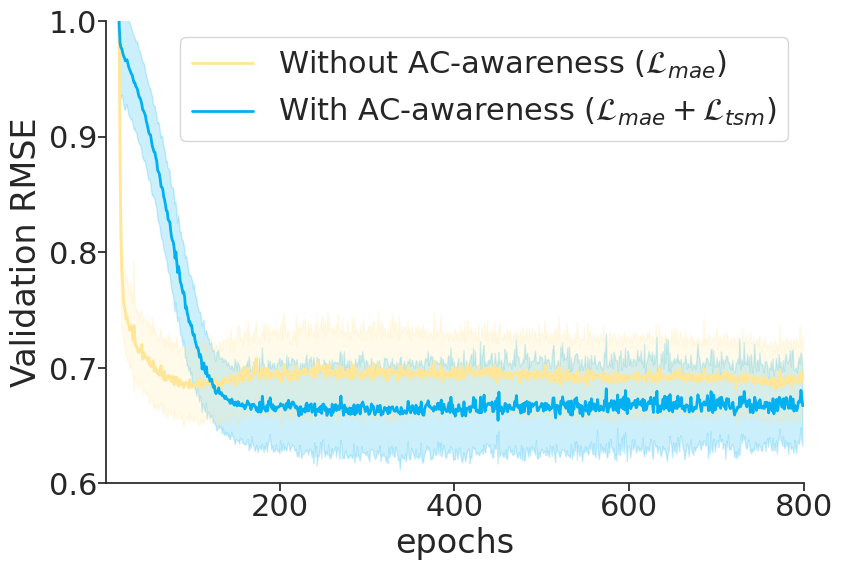

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'val_rmse'

n1 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
n2 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'


dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Validation_RMSE.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Validation_RMSE.pdf', bbox_inches='tight', dpi=400) 

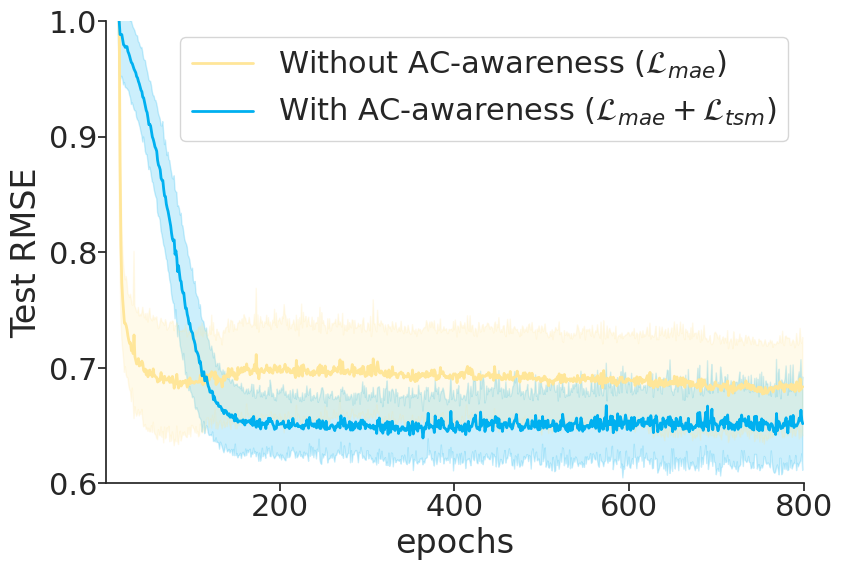

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'test_rmse'



dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Test_RMSE.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Test_RMSE.pdf' , bbox_inches='tight', dpi=400) 

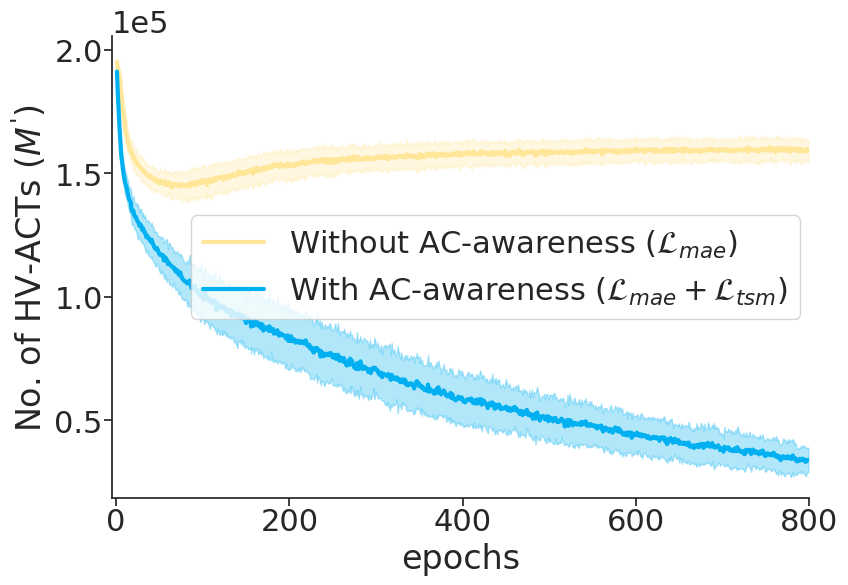

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))


y = 'n_pos_triplets'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.spines[['right', 'top']].set_visible(False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel("No. of HV-ACTs ($M^'$)")
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
ax.set_xlim(-5,800)


fig.savefig('./Number_of_mined_ACTs_during_training.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Number_of_mined_ACTs_during_training.pdf' , bbox_inches='tight', dpi=400) 

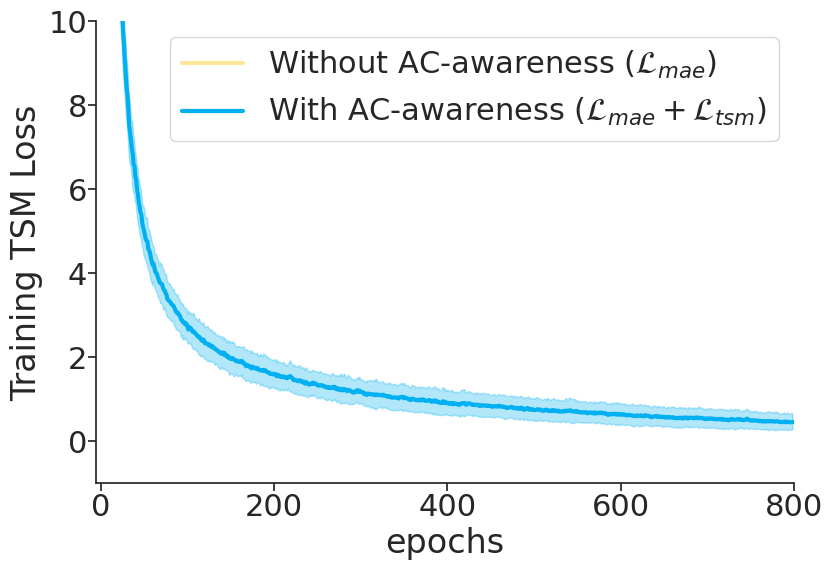

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))
y = 'train_triplet_loss'
dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-5,800)
ax.set_ylim(-1,10)

ax.set_ylabel('Training TSM Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Triplet_loss_during_training.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Triplet_loss_during_training.pdf', bbox_inches='tight', dpi=400) 

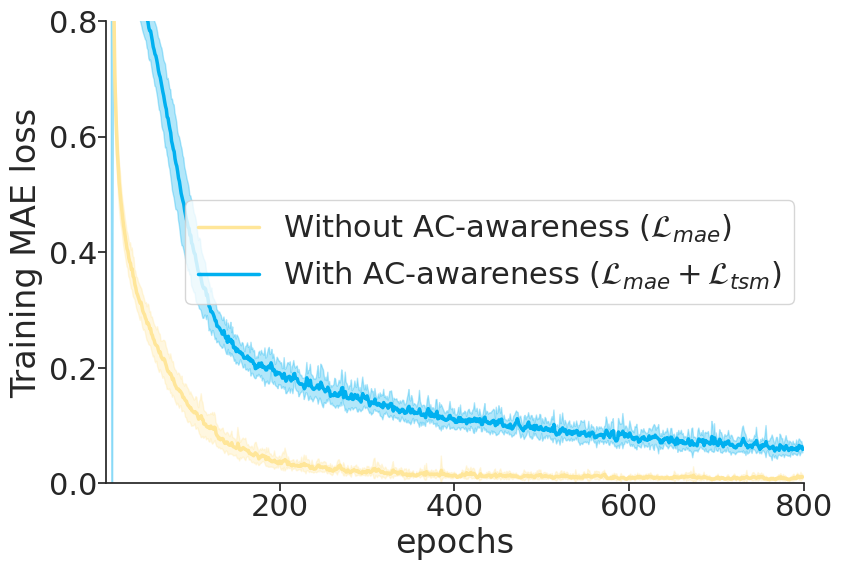

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))

y = 'train_mae_loss'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2.5, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.set_ylim(0.0, 0.8)
ax.spines[['right', 'top']].set_visible(False)


ax.set_ylabel('Training MAE loss')
ax.set_xlabel('epochs')
ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Train_mae_los.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Train_mae_los.pdf', bbox_inches='tight', dpi=400) 